# Part 1A: Data Preprocessing

In this part of the tutorials, you will be guided through the different parsing steps needed to ensure high-quality and consistent data formats. <br>
<br>
This includes: 
- Loading the data
- Remove entries with missing data
- Remove CDR3β sequences containing non-amino acid characters
- Remove CDR3β sequences not starting/ending with the conserved cysteine (C) and end with a phenylalanine (F) residue
- Merging and excluding duplicate sequences from the data


In [1]:
# clone the TCR workshop github repository and its data
!git clone https://github.com/vincentvandeuren/tcr_workshop_2023.git

# change your working directory
%cd tcr_workshop_2023

# Check if the tcr_workshop_2023 folder is available in the file menu, you might have to press refresh

Cloning into 'tcr_workshop_2023'...
remote: Enumerating objects: 425, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 425 (delta 12), reused 24 (delta 7), pack-reused 392
Receiving objects: 100% (425/425), 40.55 MiB | 8.47 MiB/s, done.
Resolving deltas: 100% (124/124), done.
/home/vincent/Documents/projects/tcr_workshop_2023/notebooks/tcr_workshop_2023


In [2]:
# If on google colab:
# Install pyteomics package if not installed already
!pip install pyteomics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.1/235.1 kB 6.9 MB/s eta 0:00:00


In [2]:
# Import necessary packages
import pandas as pd
from pyteomics import parser

In [3]:
# Read in the correct data files for the patient at different time points (day 0 and day 15)
P1_0 = pd.read_csv('data/P1_0_sample.tsv', sep='\t', index_col=[0])
P1_15 = pd.read_csv('data/P1_15_sample.tsv', sep='\t', index_col=[0])

In [4]:
# Show an example of how the data looks
P1_0

,v_call,j_call,junction_aa,duplicate_count,frequency
0,TRBV6-2,TRBJ2-1,CASSNSDRTYGDNEQFF,33422.0,2.171360e-02
1,TRBV24-1,TRBJ2-5,CATSSVLTQQETQYF,24502.0,1.591845e-02
2,TRBV12-3,TRBJ2-3,CASSSRGLANTQYF,22361.0,1.452749e-02
3,TRBV29-1,TRBJ2-7,CSVVGADTYEQYF,20930.0,1.359780e-02
4,TRBV7-8,TRBJ1-1,CASSLGTALNTEAFF,20193.0,1.311898e-02
...,...,...,...,...,...
99711,TRBV28,TRBJ2-3,CASSPRGDPSTDTQYF,1.0,6.496797e-07
99712,TRBV27,TRBJ2-1,CASSLSGTSYEQFF,1.0,6.496797e-07
99713,TRBV20-1,TRBJ2-1,CSATGFSYTEQFF,1.0,6.496797e-07
99714,TRBV19,TRBJ2-5,CASSVGGGQALWGETQYF,1.0,6.496797e-07


In [8]:
# Define all standard amino acids
def is_amino_acid(cdr3):
    # Check if all amino acids in CDR3 sequence are standard amino acids
    # (i.e., they are present in the pyteomics parser's list of standard amino acids)
    return all(aa in parser.std_amino_acids for aa in cdr3)

# Define parsing function
def parse_data(dataframe):

    # Select only the sequences with known amino acids
    # (i.e., sequences that only contain standard amino acids)
    aa_parser = dataframe[dataframe['junction_aa'].apply(is_amino_acid)]

    # Make sure each sequence starts with C and ends with F
    start_c = aa_parser['junction_aa'].str.startswith('C', na=False)
    end_f = aa_parser['junction_aa'].str.endswith('F', na=False)
    parse_result = aa_parser[start_c & end_f].reset_index(drop=True)

    # Sum the clone counts for duplicate TCRs and merge into one entry
    parse_result['Total_count'] = parse_result.groupby(['junction_aa','v_call','j_call'])['duplicate_count'].transform('sum')
    parse_result['Total_frequency'] = parse_result.groupby(['junction_aa','v_call','j_call'])['frequency'].transform('sum')
    parse_result = parse_result[['junction_aa', 'v_call', 'j_call', 'Total_count', 'Total_frequency']]
    parse_result.drop_duplicates(subset=['junction_aa', 'v_call', 'j_call'], inplace=True)

    # Add 'productive' column, required by the AIRR format and TCRex
    parse_result['productive'] = True

    return parse_result


# Define a function to apply column extraction and data parsing on the dataframe
def full_parsing(data):
    Parsing = parse_data(data)

    # Show the number of TCRs before and after parsing, as well as the number of TCRs removed
    print(f'The number of TCRs before parsing is: {len(data)}')
    print(f'The number of TCRs after parsing is: {len(Parsing)}')
    print(f'The number of TCRs removed is : {len(data) - len(Parsing)}')

    # Show the exact sequences that have been removed
    Before = data['junction_aa']
    After = Parsing['junction_aa']
    print(f'The removed sequences are : {set(Before)-set(After)} \n')

    return Parsing

In [9]:
# Perform the parsing functions define above
# For both the repertoire at day 0 and at day 15
print('Repertoire at day 0:')
P1_0_parsed = full_parsing(P1_0)

print('Repertoire at day 15:')
P1_15_parsed = full_parsing(P1_15)

Repertoire at day 0:
The number of TCRs before parsing is: 99716
The number of TCRs after parsing is: 99716
The number of TCRs removed is : 0
The removed sequences are : set() 

Repertoire at day 15:
The number of TCRs before parsing is: 84870
The number of TCRs after parsing is: 84869
The number of TCRs removed is : 1
The removed sequences are : {'CASSYPGAGDEW'} 



In [7]:
# Remove CDR3 (without V and J gene information) duplicates for clustering
P1_0_clustcr = P1_0_parsed.drop_duplicates(subset=['junction_aa'])
P1_15_clustcr = P1_15_parsed.drop_duplicates(subset=['junction_aa'])

# Save these parsed repertoires as a tsv file for later use with clusTCR
P1_0_clustcr.to_csv('data/P1_0_parsed.tsv', sep='\t')
P1_15_clustcr.to_csv('data/P1_15_parsed.tsv', sep='\t')

# Part 1B: Repertoire richness and diversity calculations

For this section of the tutorials, the use of scikit-bio for repertoire diversity calculations will be illustrated. <br>
In addition, this notebook shows you how to calculate repertoire richness and overlap between different repertoires. <br>

### Diversity calculations:
- Repertoire richness
- Shannon diversity
- Pielou's evenness
- Simpson and Gini-Simpson diversity
- Gini coefficient
- DE50

In [14]:
# If on google colab:
# Install the package needed for the diversity calculations
# More info regarding scikit-bio and its possibilities can be found here:
# http://scikit-bio.org

!pip install scikit-bio

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 5.5 MB/s eta 0:00:005.4 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 4.2 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 3.1 MB/s eta 0:00:003.1 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.8/316.8 kB 3.5 MB/s eta 0:00:003.4 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 4.3 MB/s eta 0:00:000:00:010:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [16]:
# Import necessary packages
import matplotlib.pyplot as plt
import pandas as pd
from skbio.diversity.alpha import shannon, gini_index, pielou_e, simpson

In [17]:
# Show the data we will use as input for these calculations
# The two parsed dataframes from the previous step
P1_15_parsed

,junction_aa,v_call,j_call,Total_count,Total_frequency
0,CASSNSDRTYGDNEQFF,TRBV6-2,TRBJ2-1,14403.0,1.028189e-02
1,CASSRRHLGNTGELFF,TRBV7-2,TRBJ2-2,11651.0,8.317313e-03
2,CASSPSTDTQYF,TRBV27,TRBJ2-3,10538.0,7.522774e-03
3,CASSLGTALNTEAFF,TRBV7-8,TRBJ1-1,10238.0,7.308613e-03
4,CSVVGADTYEQYF,TRBV29-1,TRBJ2-7,10156.0,7.250075e-03
...,...,...,...,...,...
146322,CVSSLALAGASDTQYF,TRBV27,TRBJ2-3,1.0,7.138712e-07
146323,CASSPRRTSPAYEQYF,TRBV28,TRBJ2-7,1.0,7.138712e-07
146324,CASRGVVPSSYNEQFF,TRBV28,TRBJ2-1,1.0,7.138712e-07
146325,CASSSGGPYNEQFF,TRBV19,TRBJ2-1,1.0,7.138712e-07


In [18]:
# Define calculations for 50th percentile diversity

def get_50th_percentile(data):
    # Sort the data from high to low clonal frequency
    data.sort_values(by='Total_frequency', ascending=False)

    # Calculate the cummulative frequency per sequence
    data['cumulative_sum'] = data['Total_frequency'].cumsum()

    # Identify the number of clones needed to reach the threshold value
    First_index = data[data.cumulative_sum >= 0.5].index[0]
    Ratio = First_index/len(data)
    return Ratio

In [20]:
# Calculate all diversity metrics and combine results in a single dataframe
Dataframes = [P1_0_parsed, P1_15_parsed]
Patients = ['P1_0', 'P1_15']
Df = []

for i, j in zip(Dataframes, Patients):

    # Set patient identifier, in this case pre- and post-vaccination
    Patient_id = j

    # Calculate richness = the number of unique TCR sequences in the repertoire
    Richness = len(i)

    # Calculate several diversity metrics using scikit-bio
    Shannon = shannon(i['Total_frequency'], base=2)
    Pielou = pielou_e(i['Total_frequency'])
    Simpson = simpson(i['Total_frequency'])
    Gini = gini_index(i['Total_frequency'])

    # Calculate the DE50 value using the funtion created above
    DE50 = get_50th_percentile(i)

    # Combine all results in a comprehensive dataframe
    df = pd.DataFrame({
        'Patient_id': [Patient_id],
        'Richness': [Richness],
        'Shannon_index': [Shannon],
        'Pielou_evenness': [Pielou],
        'Gini-Simpson': [Simpson],
        'DE50': [DE50],
        'Gini_coefficient': [Gini]})
    Df.append(df)

Result_df = pd.concat(Df)
Result_df.reset_index(drop=True, inplace=True)
Result_df

,Patient_id,Richness,Shannon_index,Pielou_evenness,Gini-Simpson,DE50,Gini_coefficient
0,P1_0,171923,15.133646,0.870180,0.998745,0.097084,0.571045
1,P1_15,146327,14.986591,0.873404,0.999282,0.075154,0.600210


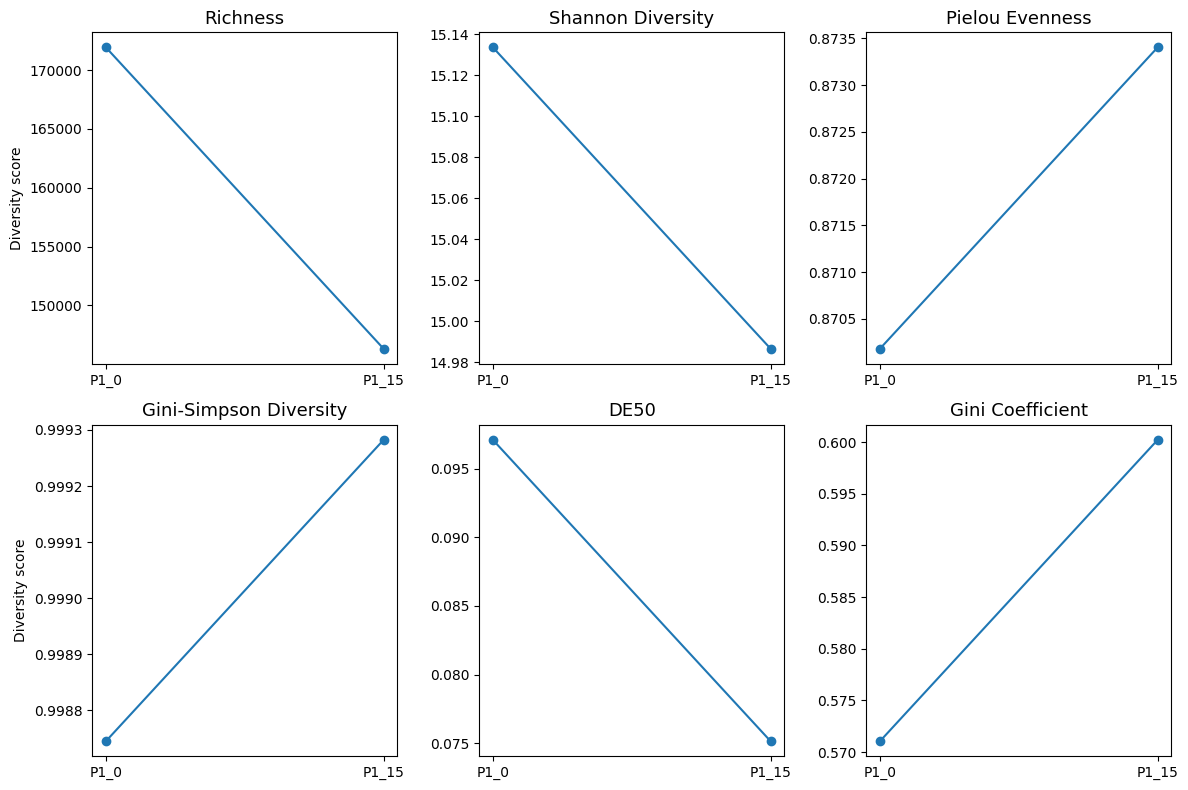

In [21]:
# Import necessary packages
import matplotlib.pyplot as plt

# Set x-axis values and select data
x = ['P1_0', 'P1_15']
Richness = [Result_df.iloc[0,1], Result_df.iloc[1,1]]
Shannon = [Result_df.iloc[0,2], Result_df.iloc[1,2]]
Pielou = [Result_df.iloc[0,3], Result_df.iloc[1,3]]
Gini_Simpson = [Result_df.iloc[0,4], Result_df.iloc[1,4]]
DE50 = [Result_df.iloc[0,5], Result_df.iloc[1,5]]
Gini = [Result_df.iloc[0,6], Result_df.iloc[1,6]]

# Set up figure and axes
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Plot Richness
axs[0, 0].plot(x, Richness, linestyle="-", marker="o", label="Richness")
axs[0, 0].set_title('Richness', fontsize=13)
axs[0, 0].set_ylabel('Diversity score', fontsize=10)

# Plot Shannon diversity
axs[0, 1].plot(x, Shannon, linestyle="-", marker="o", label="Shannon Diversity")
axs[0, 1].set_title('Shannon Diversity', fontsize=13)

# Plot Pielou evenness
axs[0, 2].plot(x, Pielou, linestyle="-", marker="o", label="Pielou Evenness")
axs[0, 2].set_title('Pielou Evenness', fontsize=13)

# Plot Gini-Simpson diversity
axs[1, 0].plot(x, Gini_Simpson, linestyle="-", marker="o", label="Gini-Simpson Diversity")
axs[1, 0].set_title('Gini-Simpson Diversity', fontsize=13)
axs[1, 0].set_ylabel('Diversity score', fontsize=10)

# Plot DE50
axs[1, 1].plot(x, DE50, linestyle="-", marker="o", label="DE50")
axs[1, 1].set_title('DE50', fontsize=13)

# Plot Gini coefficient
axs[1, 2].plot(x, Gini, linestyle="-", marker="o", label="Gini Coefficient")
axs[1, 2].set_title('Gini Coefficient', fontsize=13)

# Adjust the layout
plt.tight_layout()

# Save the figure
plt.savefig('Diversity_metrics.jpg', dpi=400)


In [22]:
# Example using pre- and post-treatment repertoires of three cancer patients that received immunotherapy
# Load the patient_comparison.csv file to explore diversity metrics between different people
Comparison_data = pd.read_csv('data/Patient_comparison.csv', index_col=[0])
Comparison_data

,Patient_id,Richness,Shannon_index,Pielou_evenness,Gini-Simpson,DE50,Gini_coefficient
0,P1_pre,15074,11.236565,0.809564,0.996644,0.054597,0.715936
1,P1_post,2720,7.902048,0.692592,0.936423,0.036765,0.730809
2,P2_pre,17976,10.256699,0.725687,0.987401,0.032655,0.802038
3,P2_post,39808,11.560222,0.756521,0.995896,0.026678,0.817275
4,P3_pre,11584,12.273467,0.909156,0.998595,0.356095,0.466271
5,P3_post,46629,11.076526,0.714203,0.995098,0.011066,0.852803


In [23]:
# Define a function to plot each diversity metric for three patients in the same plot
def get_metric_plots(dataframe, metric_index, title, ax):

    # Set x-axis values and select data
    x = ['Pre-treatment', 'Post-treatment']
    Pat1_m = [dataframe.iloc[0,metric_index], dataframe.iloc[1,metric_index]]
    Pat2_m = [dataframe.iloc[2,metric_index], dataframe.iloc[3,metric_index]]
    Pat3_m = [dataframe.iloc[4,metric_index], dataframe.iloc[5,metric_index]]

    # Plot the figure on the specified axes
    ax.plot(x, Pat1_m, linestyle="-", marker="o", label="Patient 1")
    ax.plot(x, Pat2_m, linestyle="-", marker="o", label="Patient 2")
    ax.plot(x, Pat3_m, linestyle="-", marker="o", label="Patient 3")
    ax.set_title(f'{title}', fontsize=13)
    ax.set_ylabel(f'{title} score', fontsize=10)

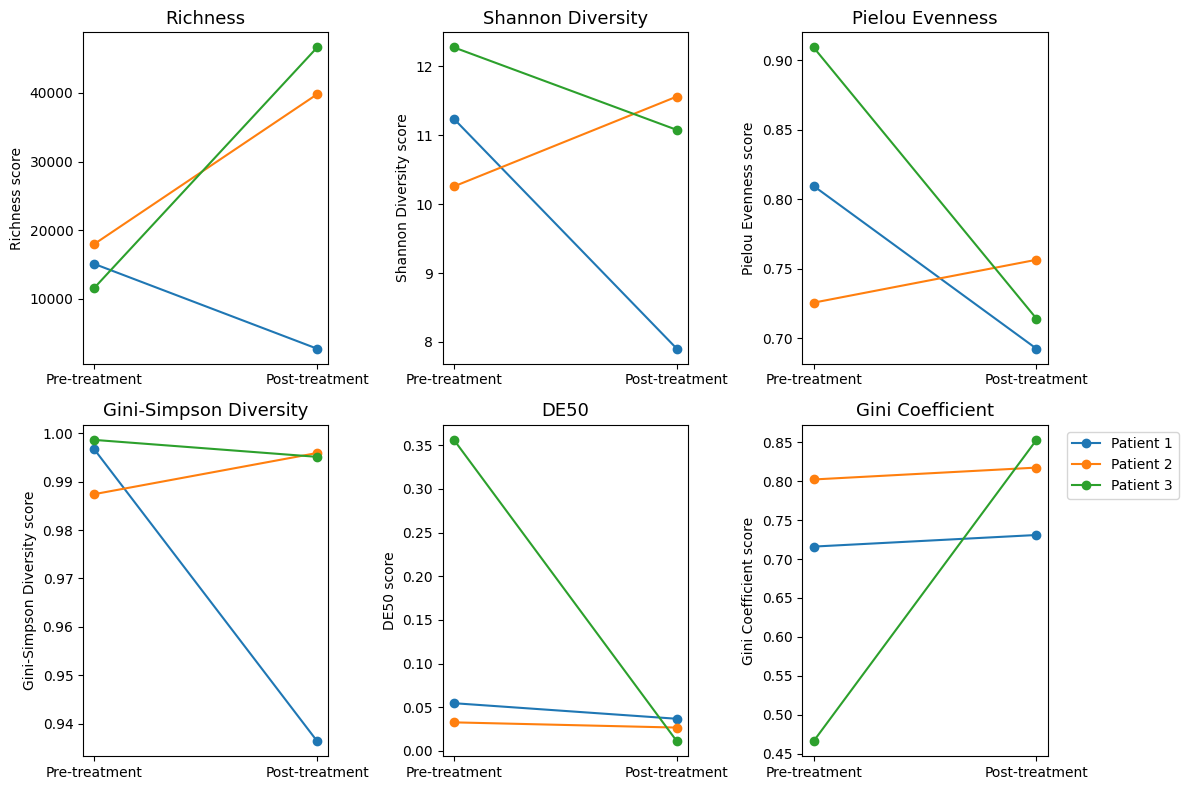

In [25]:
# Set up figure and axes
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Set x-axis values and select data
x = ['Pre-treatment', 'Post-treatment']
metrics = ['Richness', 'Shannon Diversity', 'Pielou Evenness', 'Gini-Simpson Diversity', 'DE50', 'Gini Coefficient']
metric_indices = [1, 2, 3, 4, 5, 6]

# Plot each metric on a separate subplot
for i in range(len(metrics)):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    metric = metrics[i]
    metric_index = metric_indices[i]
    get_metric_plots(Comparison_data, metric_index, metric, ax)

# Add legend and adjust layout
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the figure
plt.savefig('Diversity_comparison.jpg', dpi=400)

In [26]:
# Define Jaccard and Morisita repertoire ovelap calculations

def get_repertoire_overlap(data_p1_0, data_p1_15):

    # Merge both repertoires and discover which TCR sequences are present in both repertoires
    overlap = data_p1_0.merge(data_p1_15, how='inner', on=['junction_aa', 'v_call', 'j_call'], suffixes=['_d0','_d15'])
    
    return overlap


def get_jaccard_index(data_p1_0, data_p1_15):

    # Get the number of overlapping clones based on the full CDR3 sequence
    Cij = len(data_p1_0.merge(data_p1_15, how='inner', on=['junction_aa', 'v_call', 'j_call']))

    # Get the total number of unique clones in each repertoire
    Ni = len(data_p1_0)
    Nj = len(data_p1_15)

    # Calculate Jaccard index
    Jaccard = (Cij)/(Ni+Nj-Cij)

    return Jaccard


def get_morisita_index(data_p1_0, data_p1_15):
    
    # Get the total clone counts in the repertoires 
    n1 = data_p1_0['Total_count'].sum()
    n2 = data_p1_15['Total_count'].sum()
    
    # Calculate clone count frequency of every TCR in the repertoires (i.e. N1i/N1 and N2i/N2)
    data_p1_0['Clone_frequency']=data_p1_0['Total_count']/n1
    data_p1_15['Clone_frequency']=data_p1_15['Total_count']/n2
    
    # Get public TCRs
    public = data_p1_0.merge(data_p1_15, how='inner', on=['junction_aa', 'v_call', 'j_call'], suffixes=['_1','_2'])
    
    # Calculate product of clone count for every public TCR
    public['N1iN2i'] = public['Total_count_1']*public['Total_count_2']
    
    # Calculate morisita index
    numerator = 2*(public['N1iN2i'].sum())
    denominator = (public['Clone_frequency_1'].sum() + public['Clone_frequency_2'].sum())*n1*n2
    morisita_index = numerator/denominator
    
    return morisita_index

In [27]:
# Get the number of TCR sequences that are present in both the pre- and post-vaccination repertoire
Overlap = get_repertoire_overlap(P1_0_parsed, P1_15_parsed)
print('The overlap between pre and post is', len(Overlap), 'TCRs')

# Get the Jaccard index between both repertoires
Jaccard = get_jaccard_index(P1_0_parsed, P1_15_parsed)
print('The Jaccard index is:', '{:.4f}'.format(Jaccard))

# Get the Morisita index between both repertoires
Morisita = get_morisita_index(P1_0_parsed, P1_15_parsed)
print('The Morisita index is:', '{:.4f}'.format(Morisita))

The overlap between pre and post is 9061 TCRs
The Jaccard index is: 0.0293
The Morisita index is: 0.0025


In [28]:
# Show the overlapping TCR sequences between both repertoires
Overlap

,junction_aa,v_call,j_call,Total_count_pre,Total_frequency_pre,cumulative_sum_pre,Total_count_post,Total_frequency_post,cumulative_sum_post
0,CASSNSDRTYGDNEQFF,TRBV6-2,TRBJ2-1,33422.0,1.654679e-02,0.016547,14403.0,0.010282,0.010282
1,CATSSVLTQQETQYF,TRBV24-1,TRBJ2-5,24502.0,1.213062e-02,0.028677,7797.0,0.005566,0.065386
2,CASSSRGLANTQYF,TRBV12-3,TRBJ2-3,22361.0,1.107064e-02,0.039748,8909.0,0.006360,0.054217
3,CSVVGADTYEQYF,TRBV29-1,TRBJ2-7,20930.0,1.036217e-02,0.050110,10156.0,0.007250,0.040681
4,CASSLGTALNTEAFF,TRBV7-8,TRBJ1-1,20193.0,9.997287e-03,0.060107,10238.0,0.007309,0.033431
...,...,...,...,...,...,...,...,...,...
9056,CSVADRDGYTF,TRBV29-1,TRBJ1-2,1.0,4.950868e-07,0.999888,15.0,0.000011,0.480568
9057,CASNERVTEAFF,TRBV6-1,TRBJ1-1,1.0,4.950868e-07,0.999889,15.0,0.000011,0.481682
9058,CASSAGTANTEAFF,TRBV6-4,TRBJ1-1,1.0,4.950868e-07,0.999891,18.0,0.000013,0.447744
9059,CATSRDRGGATDTQYF,TRBV15,TRBJ2-3,1.0,4.950868e-07,0.999940,3.0,0.000002,0.936654
